In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
daily_ts = pd.read_csv('724940_daily_ts.csv')
daily_ts.head()

,YYYY-MM-DD,GHI
0,1991-01-01,95.99922
1,1991-01-02,79.88263
2,1991-01-03,66.10387
3,1991-01-04,104.28998
4,1991-01-05,92.72703


In [7]:
daily_ts['YYYY-MM-DD'] = pd.to_datetime(daily_ts['YYYY-MM-DD'])  
daily_ts = daily_ts.rename({'YYYY-MM-DD':'DATE'}, axis = 1)

In [8]:
daily_ts = daily_ts.set_index('DATE')
daily_ts.head()

,GHI
DATE,
1991-01-01,95.99922
1991-01-02,79.88263
1991-01-03,66.10387
1991-01-04,104.28998
1991-01-05,92.72703


In [9]:
daily_ts.tail()

,GHI
DATE,
2005-12-27,29.45757
2005-12-28,98.15594
2005-12-29,40.87997
2005-12-30,25.20833
2005-12-31,57.21090


## Use data from 2001 to 2005

In [10]:
daily_ts_short = daily_ts.loc['2001':'2005']

In [11]:
print(daily_ts_short.dtypes)

GHI    float64
dtype: object


## Using Montly series for Modeling

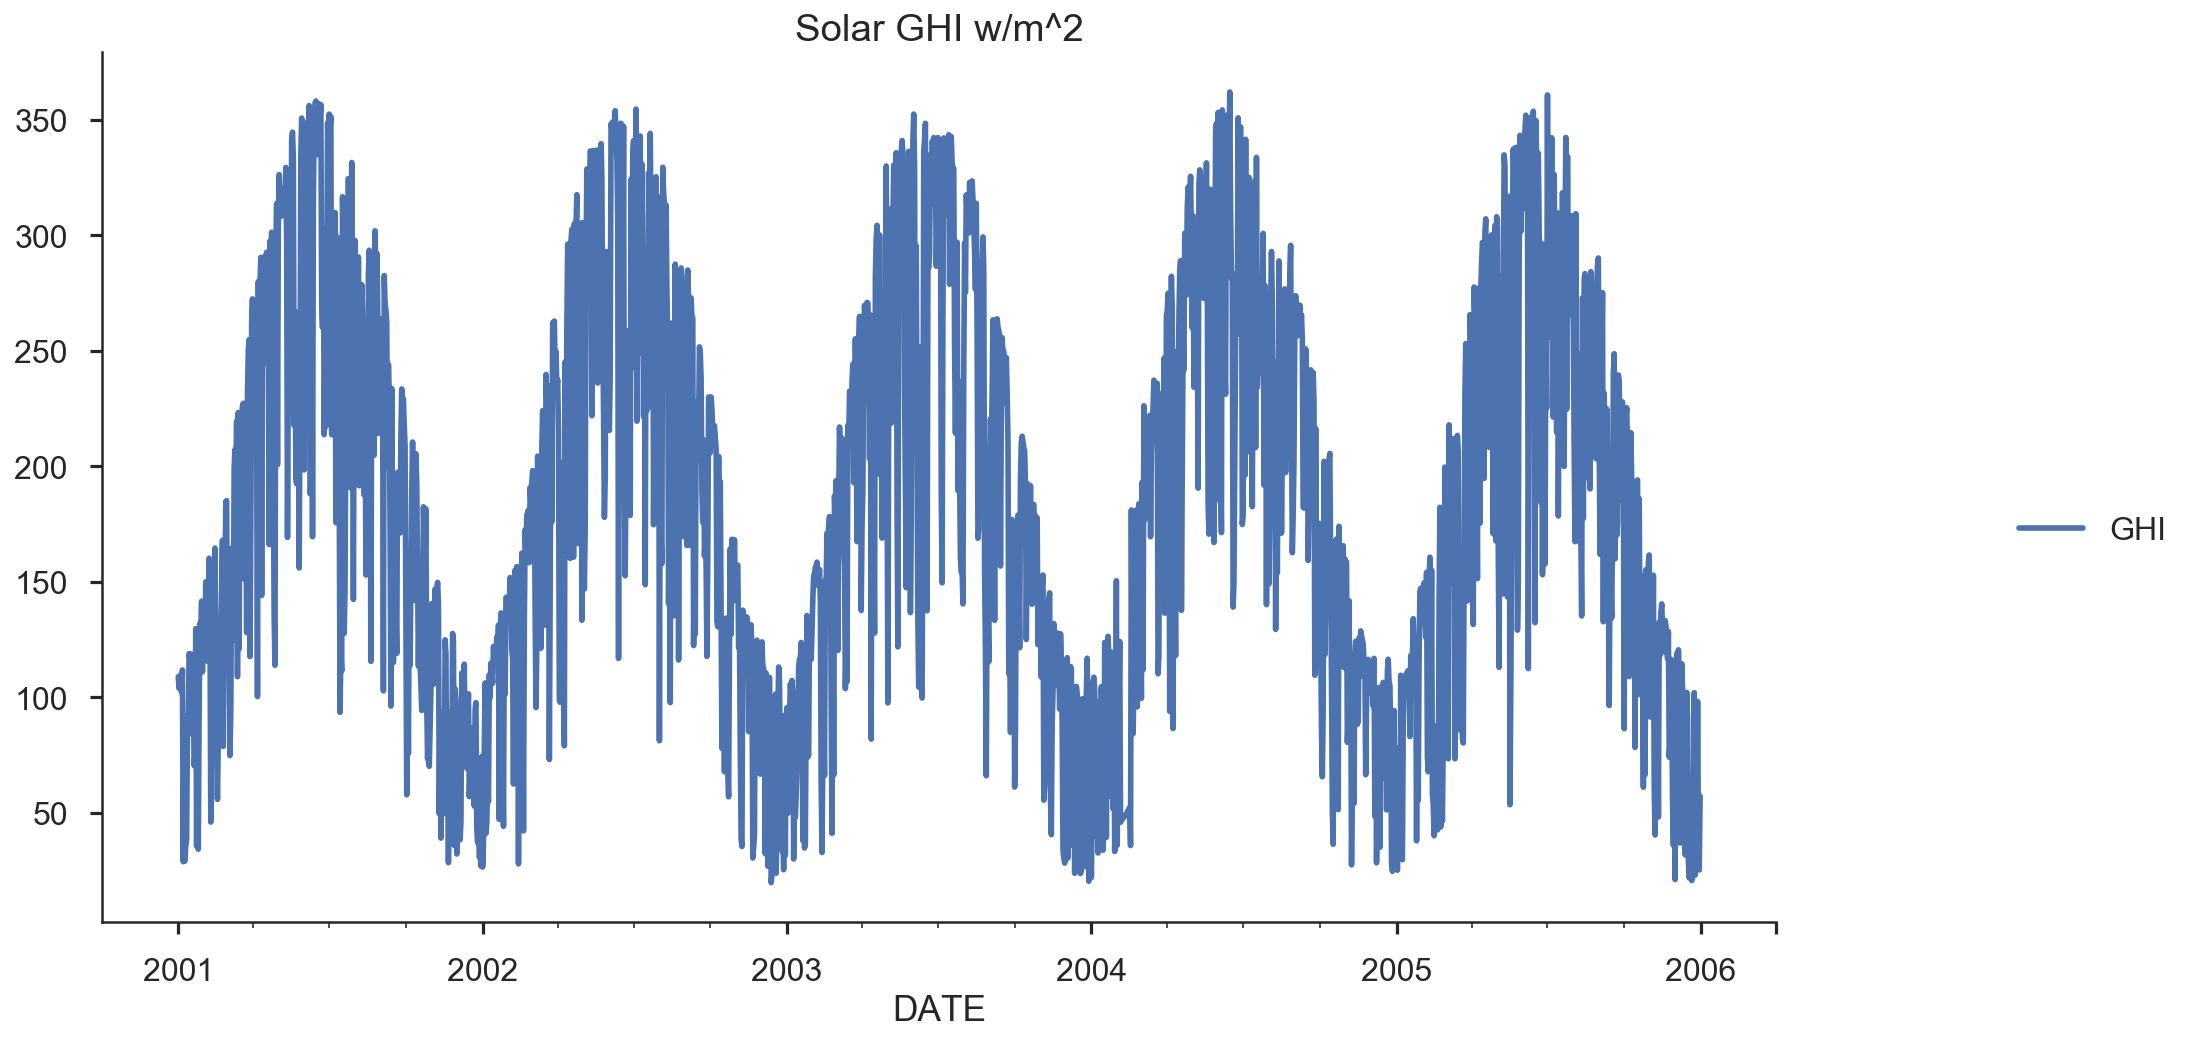

In [13]:
daily_ts_short.plot(figsize=(15,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Solar GHI w/m^2")
sns.despine()

### Highly seasonal Year Over Year

It is make sense use difference transformation with period of 365

In [14]:
daily_ts_short.shape[0] / 5.0

365.2

In [15]:
[sum(daily_ts_short.index.year == i) for i in range(2001, 2006)]

[365, 365, 365, 366, 365]

### Remove the extra day in the leap year

In [16]:
def is_leap_and_feb29(s):
    return (s.index.year % 4 == 0) & \
           ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & \
           (s.index.month == 2) & (s.index.day == 29)

In [17]:
daily_ts_short = daily_ts_short.loc[~is_leap_and_feb29(daily_ts_short)]

In [18]:
daily_ts_short.shape[0] / 5.0

365.0

In [19]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [20]:
diff_daily_ts_short = difference(daily_ts_short['GHI'], interval=365)

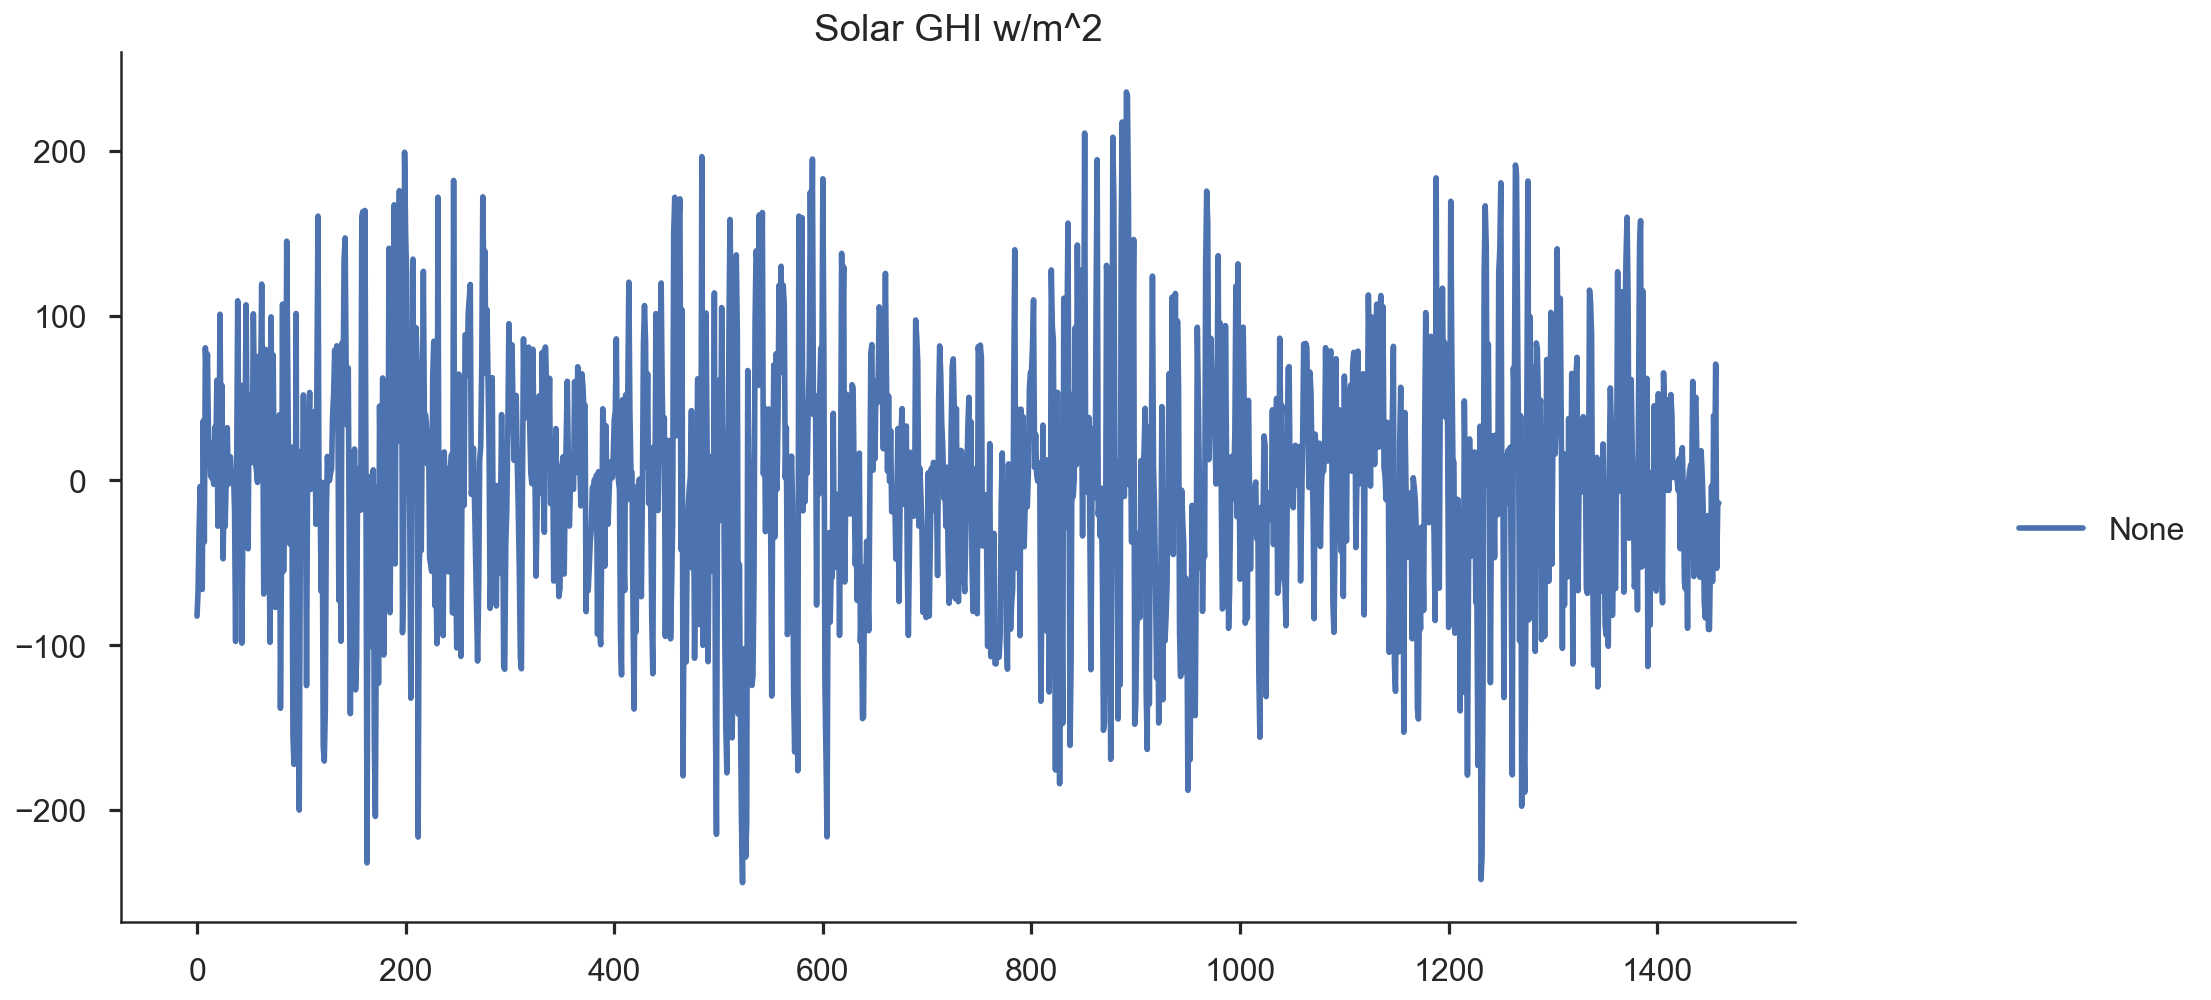

In [21]:
diff_daily_ts_short.plot(figsize=(15,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Solar GHI w/m^2")
sns.despine()

### Visual Examination

### Plot ACF and PACF

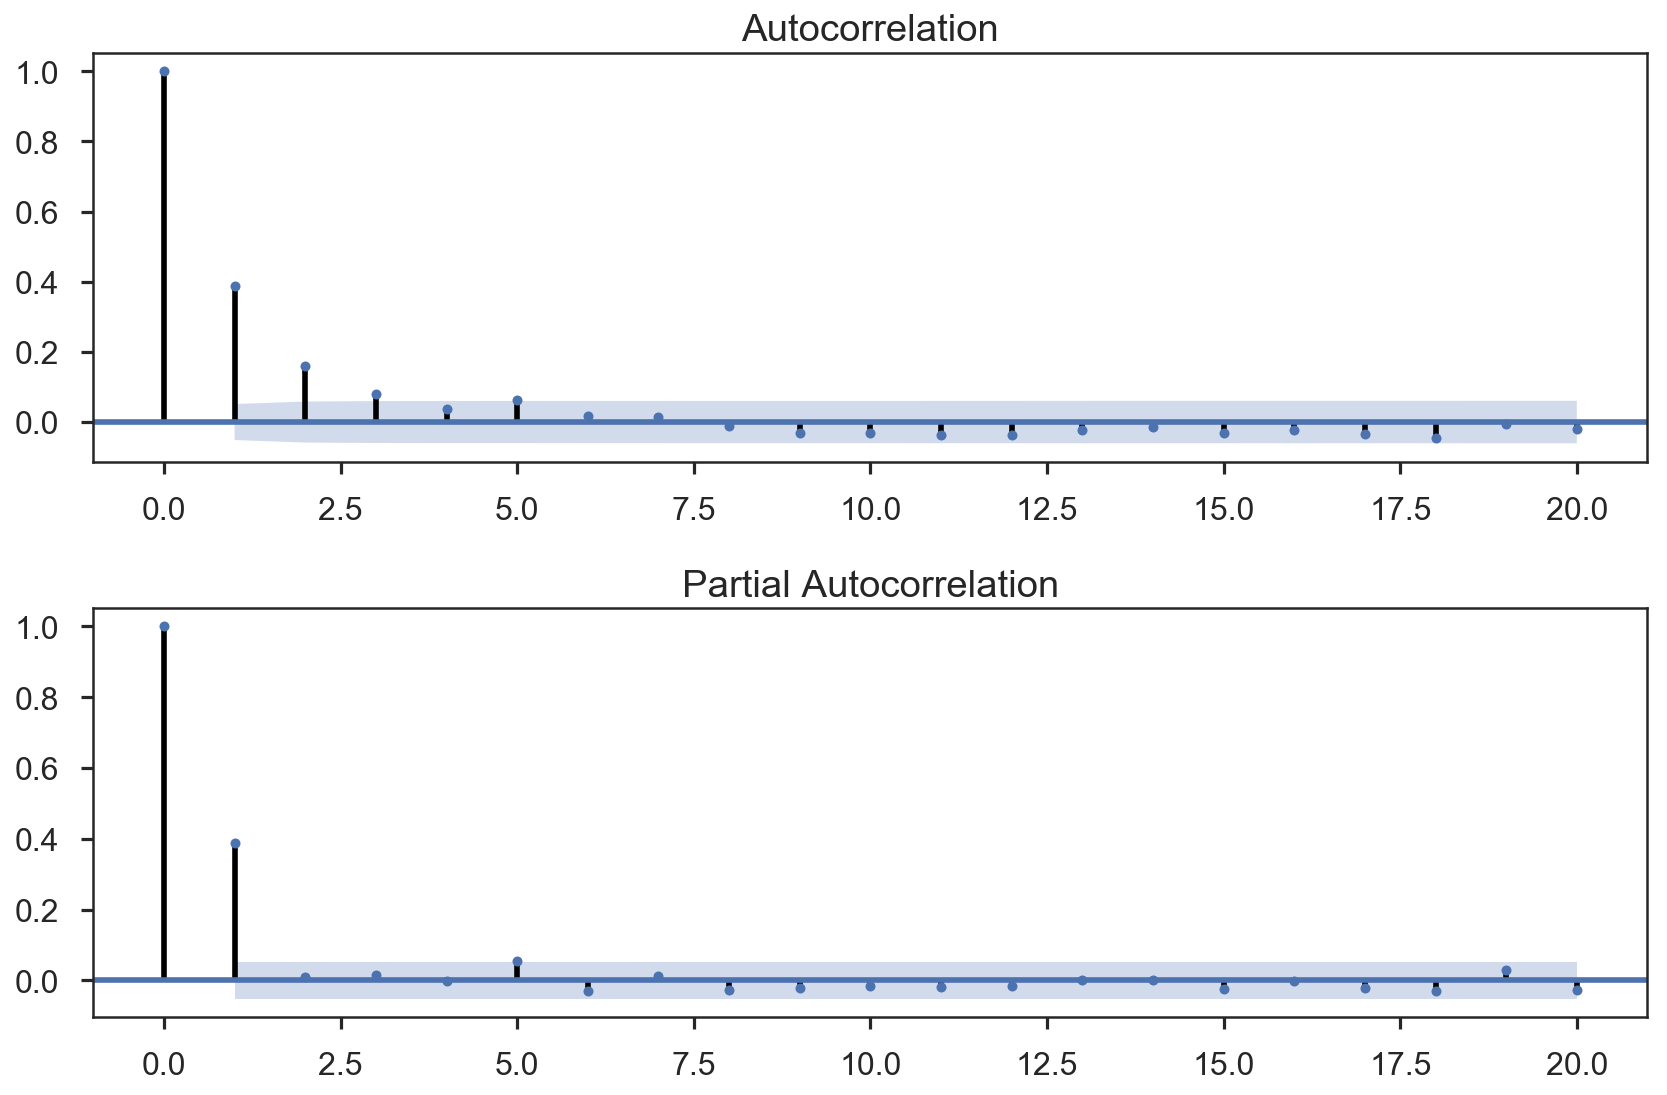

In [22]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_daily_ts_short, lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_daily_ts_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Another visual exploration is scatter matrix plot

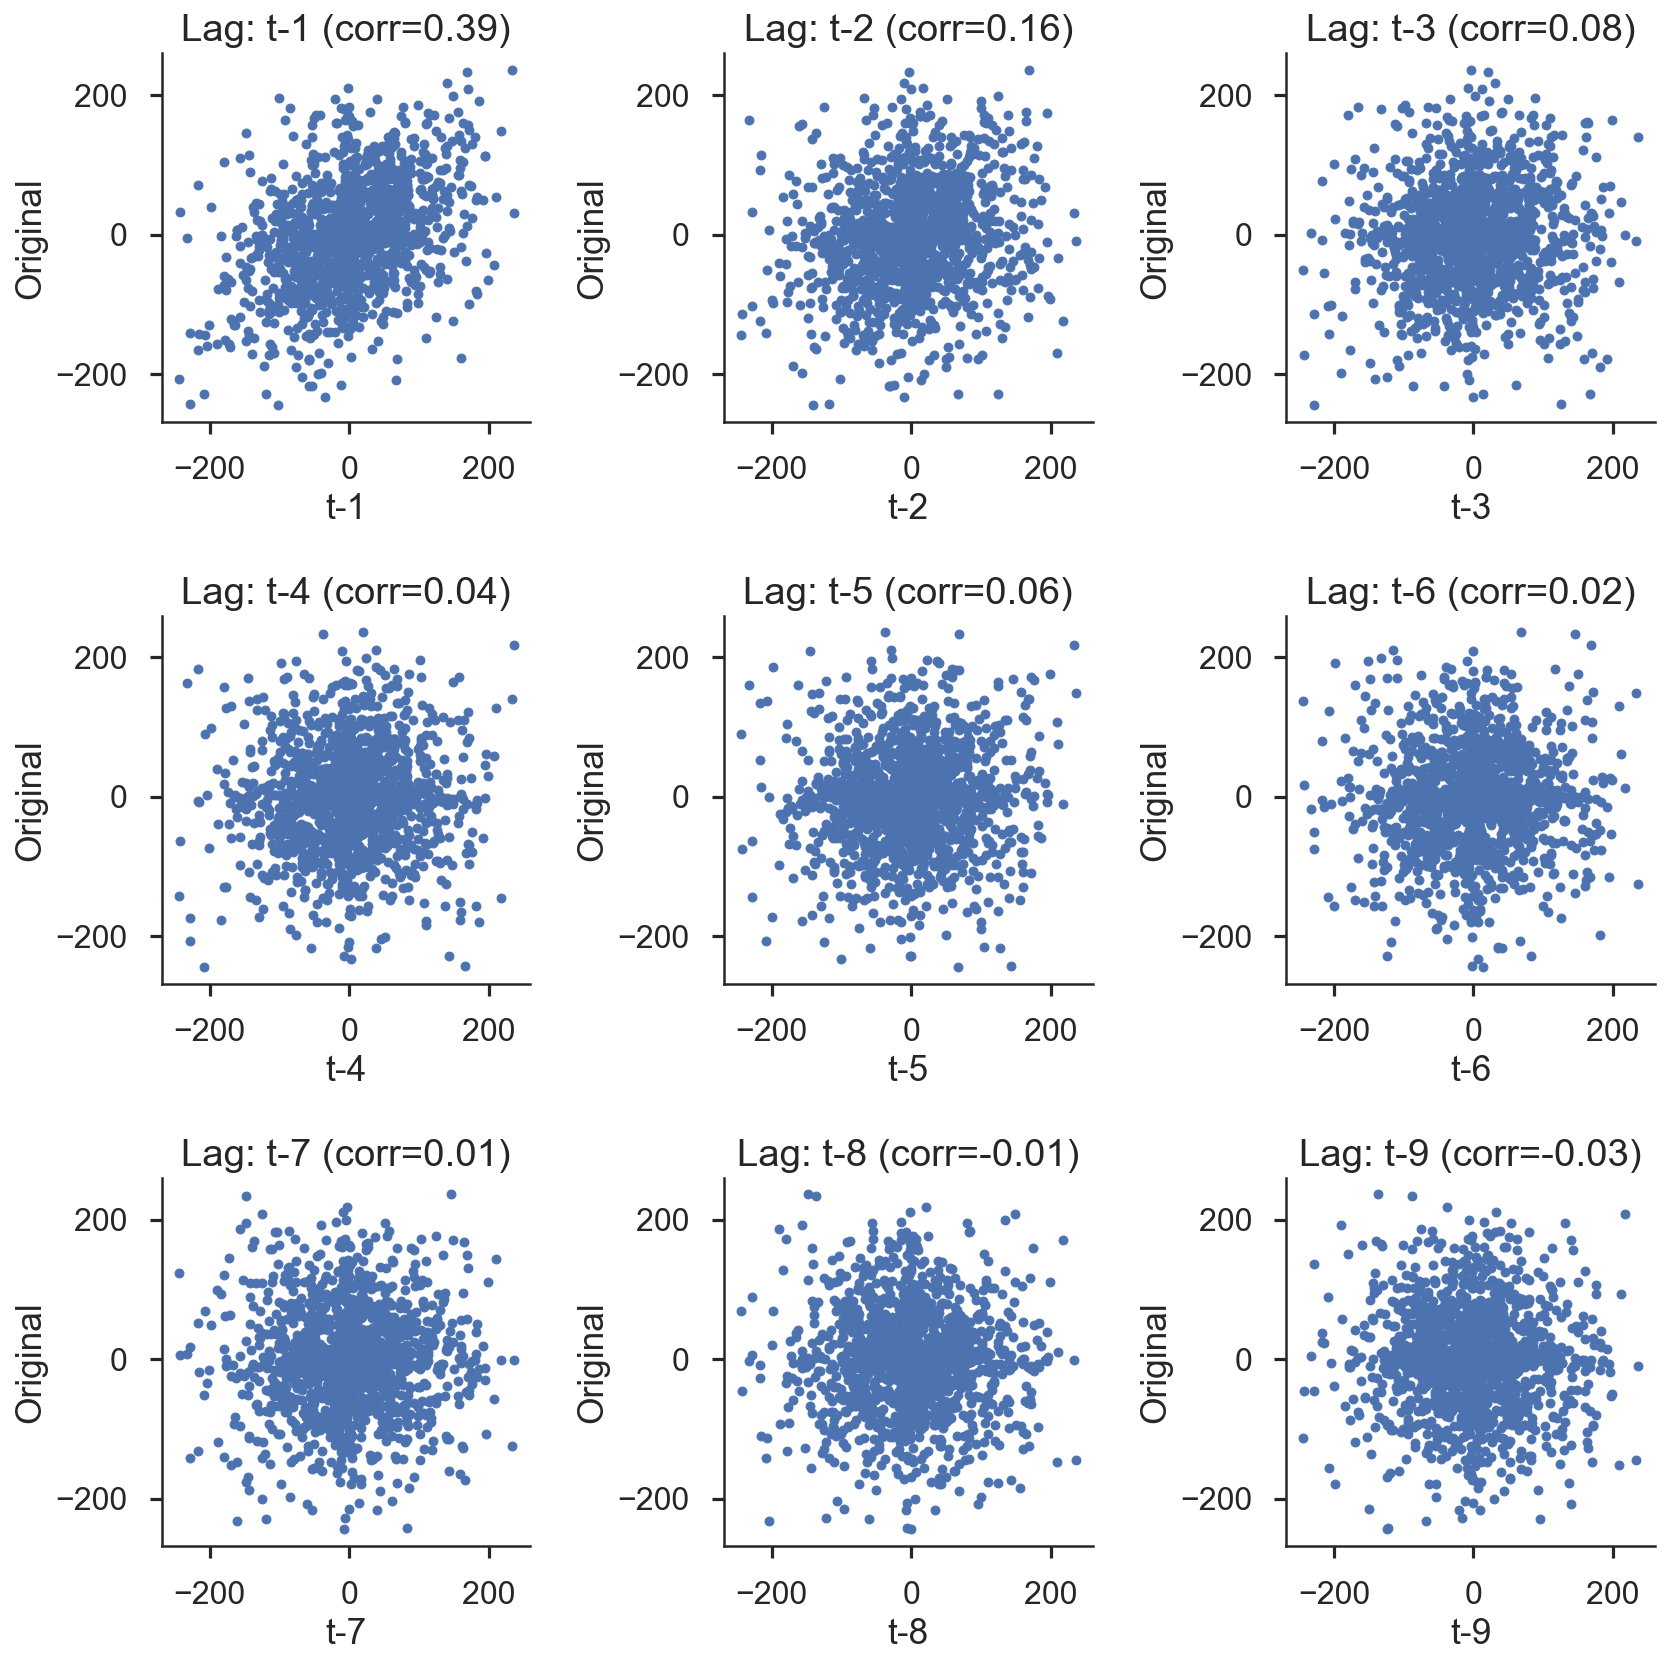

In [23]:
# Scatterplot matrix is another way to visualize the autocorrelation
# Its advantage is that it is very intuitive, as scatterplot (i.e. one of the plots in a scatterplot matrix) 
# is used often in practice

lags=9

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([diff_daily_ts_short, diff_daily_ts_short.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();

### Create a standard TS visual exploration function

In [24]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

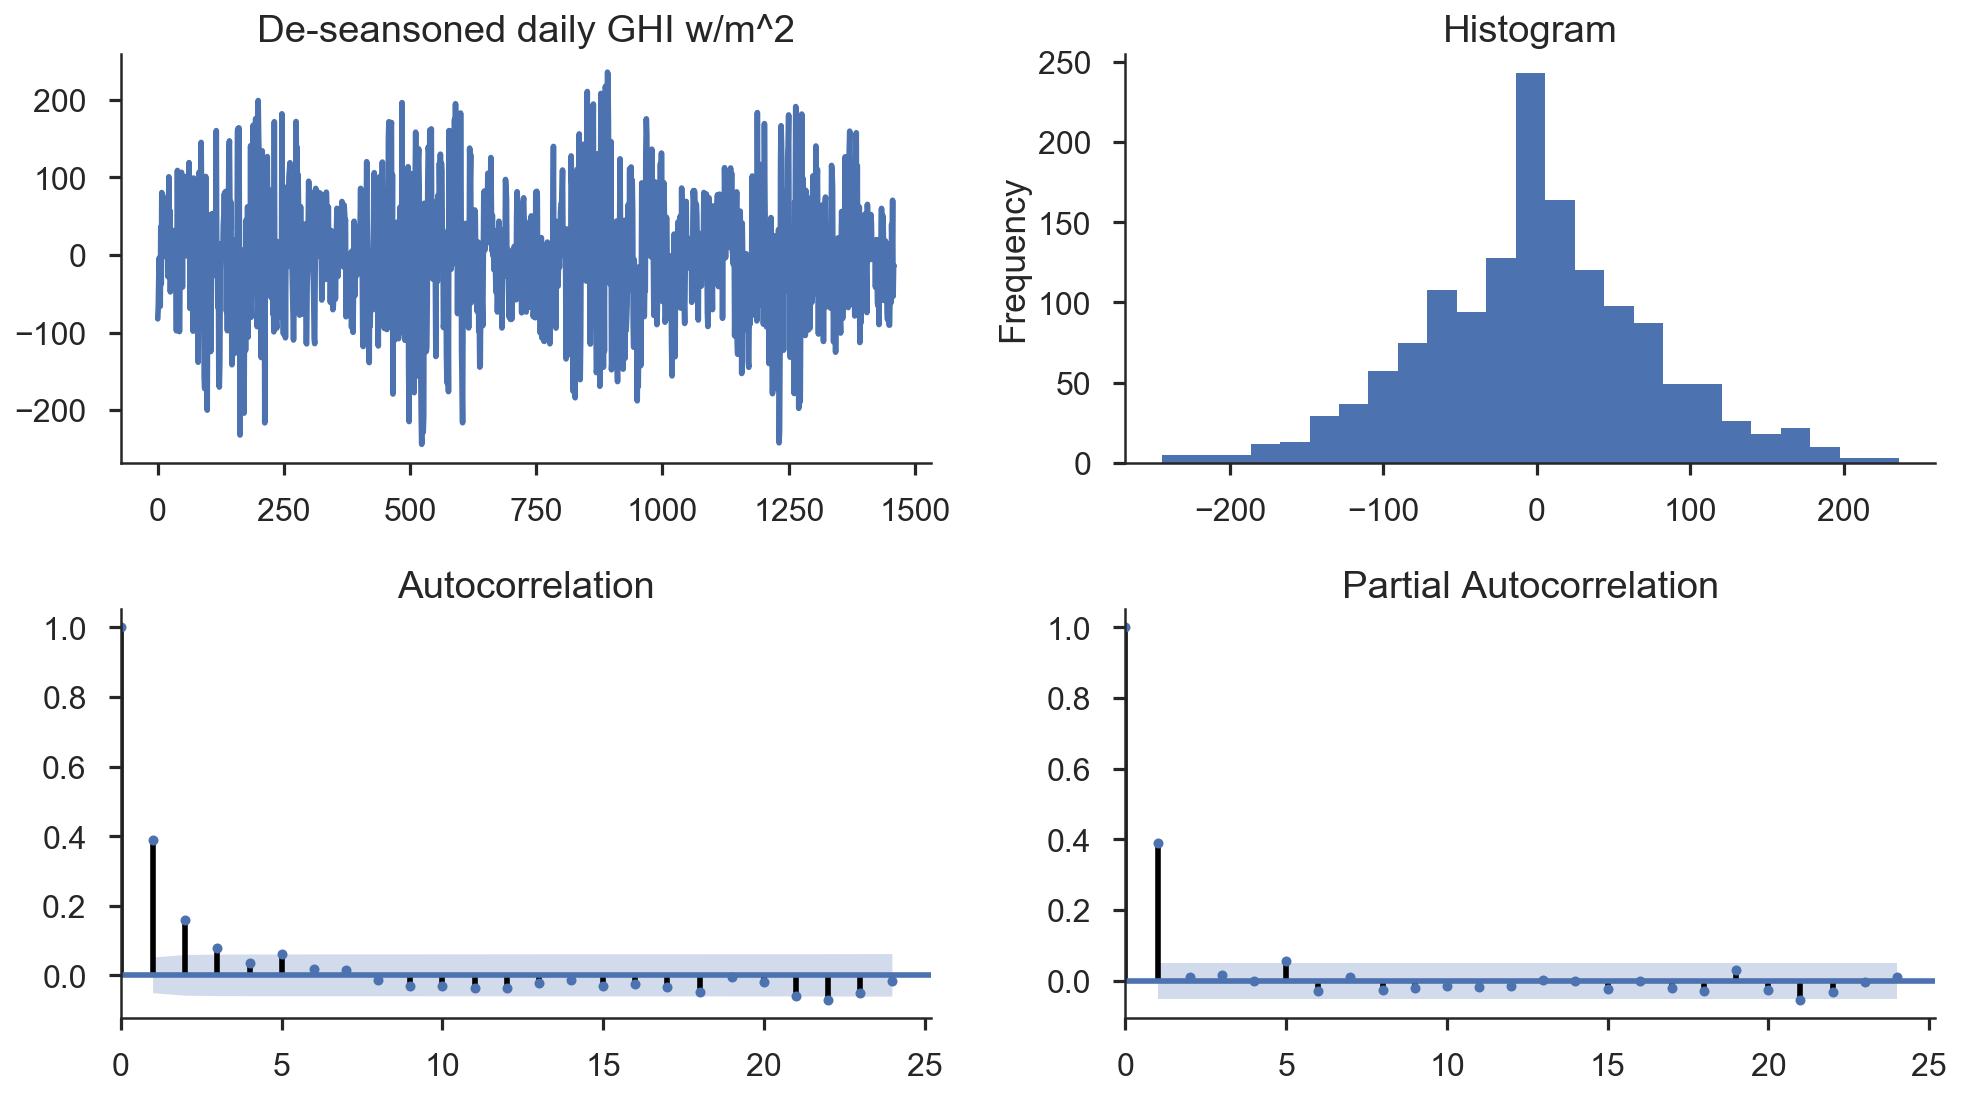

In [25]:
tsplot(diff_daily_ts_short, title='De-seansoned daily GHI w/m^2', lags=24);

## After difference transformation of yearly seaonality. The series looks to be station

## Exploring ARIMA or SARIMA Models

### Create training (95%) and testing (5%) samples

In [26]:
n_sample = daily_ts_short.shape[0]

In [27]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = daily_ts_short.iloc[:n_train]['GHI']
ts_test = daily_ts_short.iloc[n_train:]['GHI']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(1734,)
(91,)
Training Series: 
 DATE
2005-09-27   185.19159
2005-09-28   226.75888
2005-09-29   227.78411
2005-09-30   201.10260
2005-10-01    86.32717
Name: GHI, dtype: float64 

Testing Series: 
 DATE
2005-10-02   219.51090
2005-10-03   220.16136
2005-10-04   225.31361
2005-10-05   206.63656
2005-10-06   166.92145
Name: GHI, dtype: float64


### Visualize series behaviors

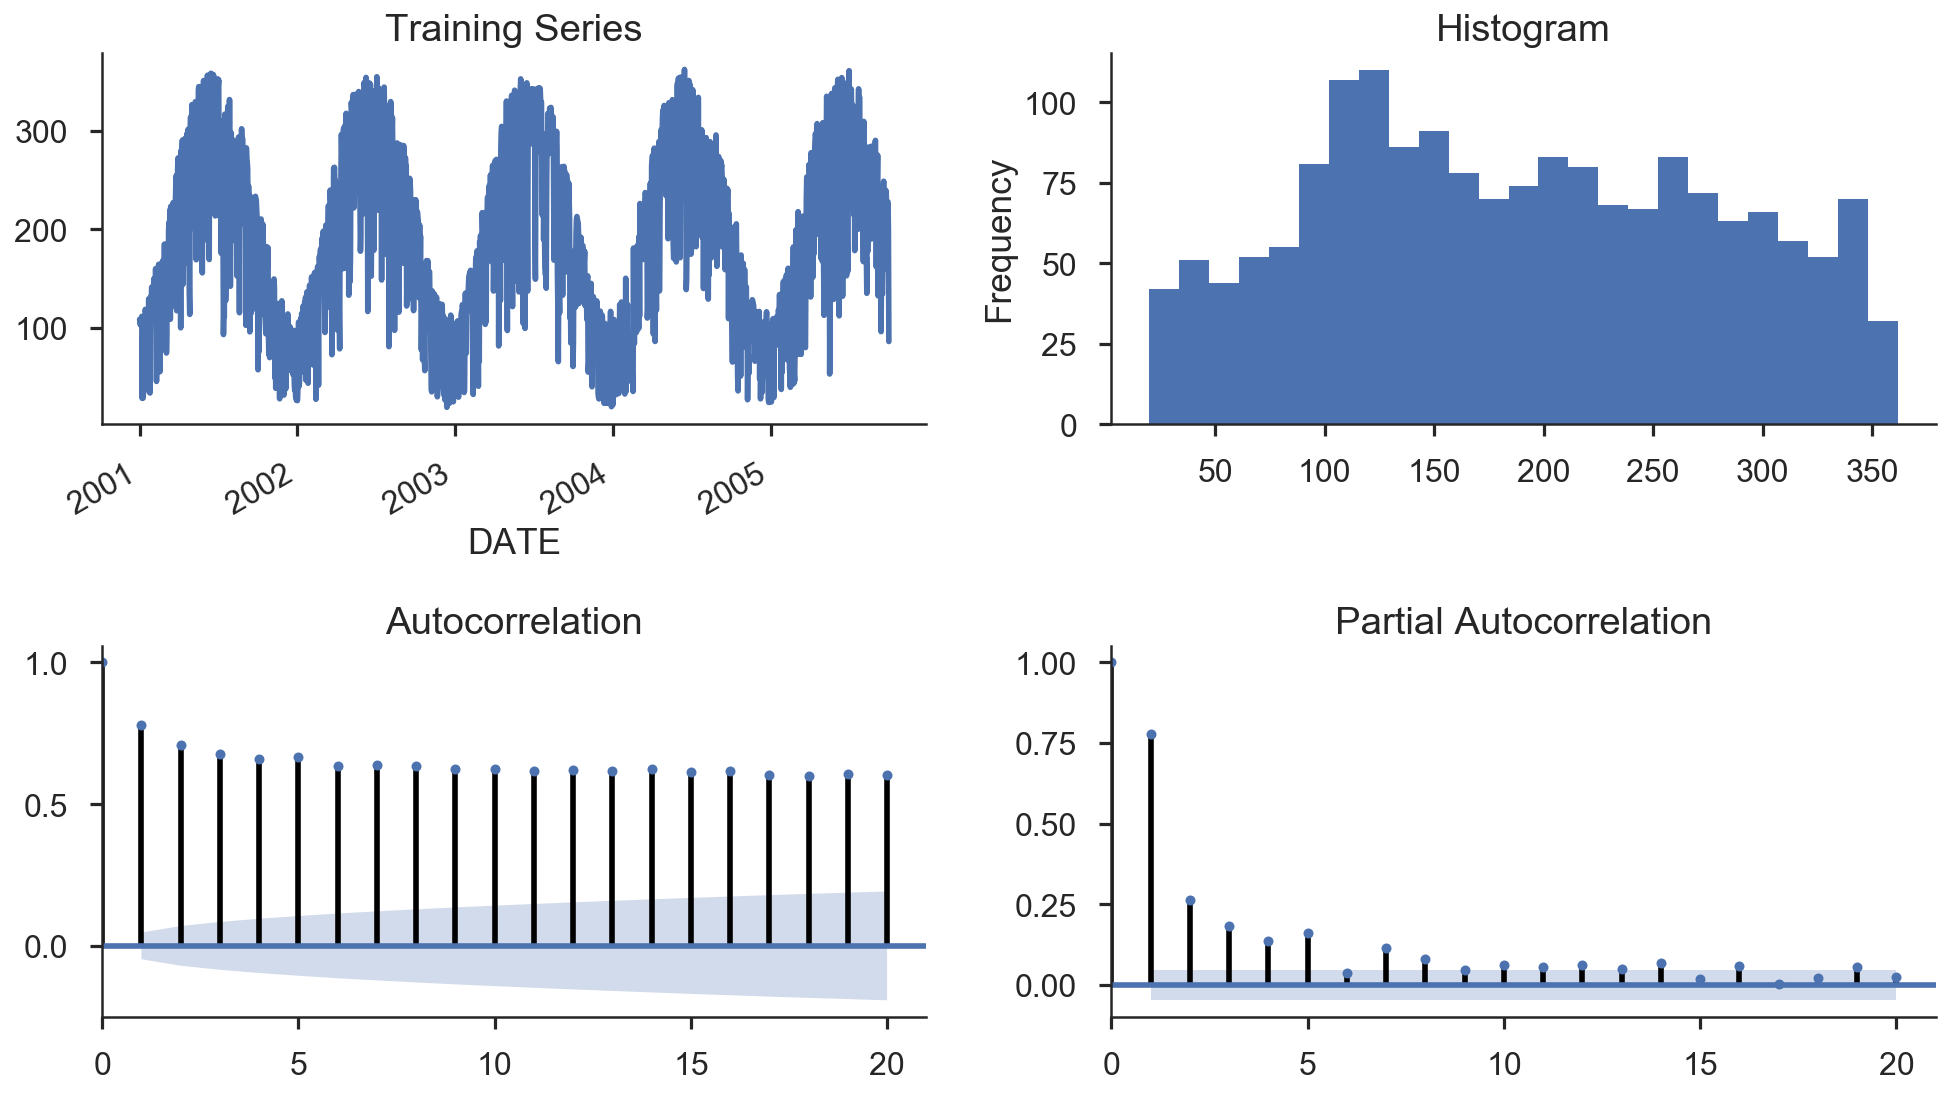

In [28]:
tsplot(ts_train, title='Training Series', lags=20);

By examing the plots:

* Highly seasonal by year
* Likely to be stationary as ACF and PACF drop off after several lags but still should experiment on integration term
* Difficult to determine the order of AR and MA

Based on the observation of the difference transformation

Try $SRARIMA (2, 0, 1) (0 0 0 365)

In [30]:
#Model Estimation

# Fit the model
sarima_t1 = sm.tsa.SARIMAX(ts_train, order=(2,0,1), seasonal_order=(0,0,0,365), simple_differencing=True)
model_results = sarima_t1.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    GHI   No. Observations:                 1734
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -9286.932
Date:                Mon, 19 Feb 2018   AIC                          18581.865
Time:                        23:24:20   BIC                          18603.698
Sample:                    01-01-2001   HQIC                         18589.939
                         - 10-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3247      0.026     51.120      0.000       1.274       1.375
ar.L2         -0.3254      0.026    -12.664      0.000      -0.376      -0.275
ma.L1         -0.8886      0.013    -67.277      0.000      -0.915      -0.863
sigma2      2621.8509     94.531     27.735      0.000    2436.573    2807.128
===================================================================================
Ljung-Box (Q):                       47.00   Jarque-Bera (JB):               105.00
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.56
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

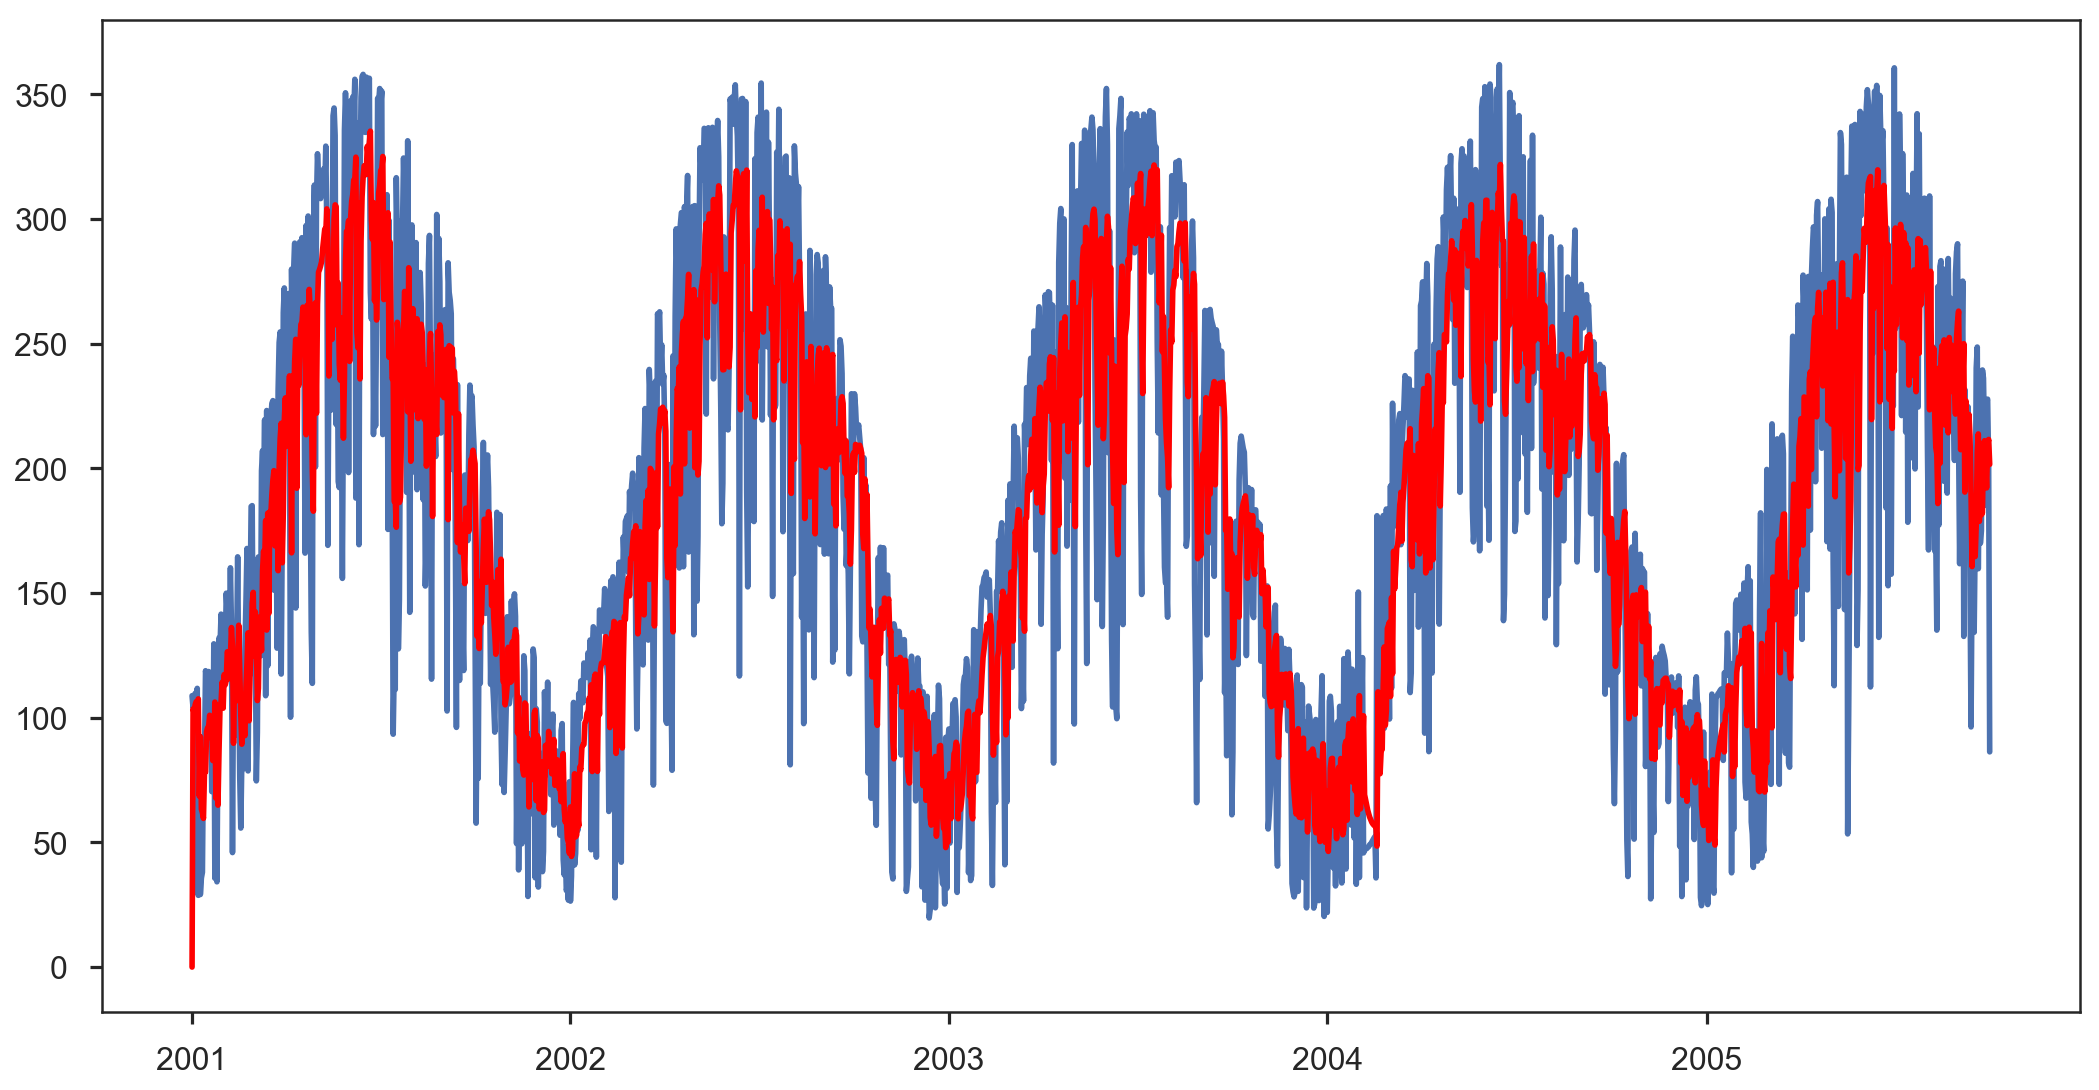

In [31]:
fig = plt.figure(figsize=(15,8))
plt.plot(ts_train)
plt.plot(model_results.fittedvalues, color = 'red')
fig.tight_layout()

### Model Diagnostic Checking

* Conduct visual inspection of the residual plots
* Residuals of a well-specified ARIMA model should mimic *Gaussian white noises*: the residuals should be uncorrelated and distributed approximated normally with mean zero and variance $n^{-1}$

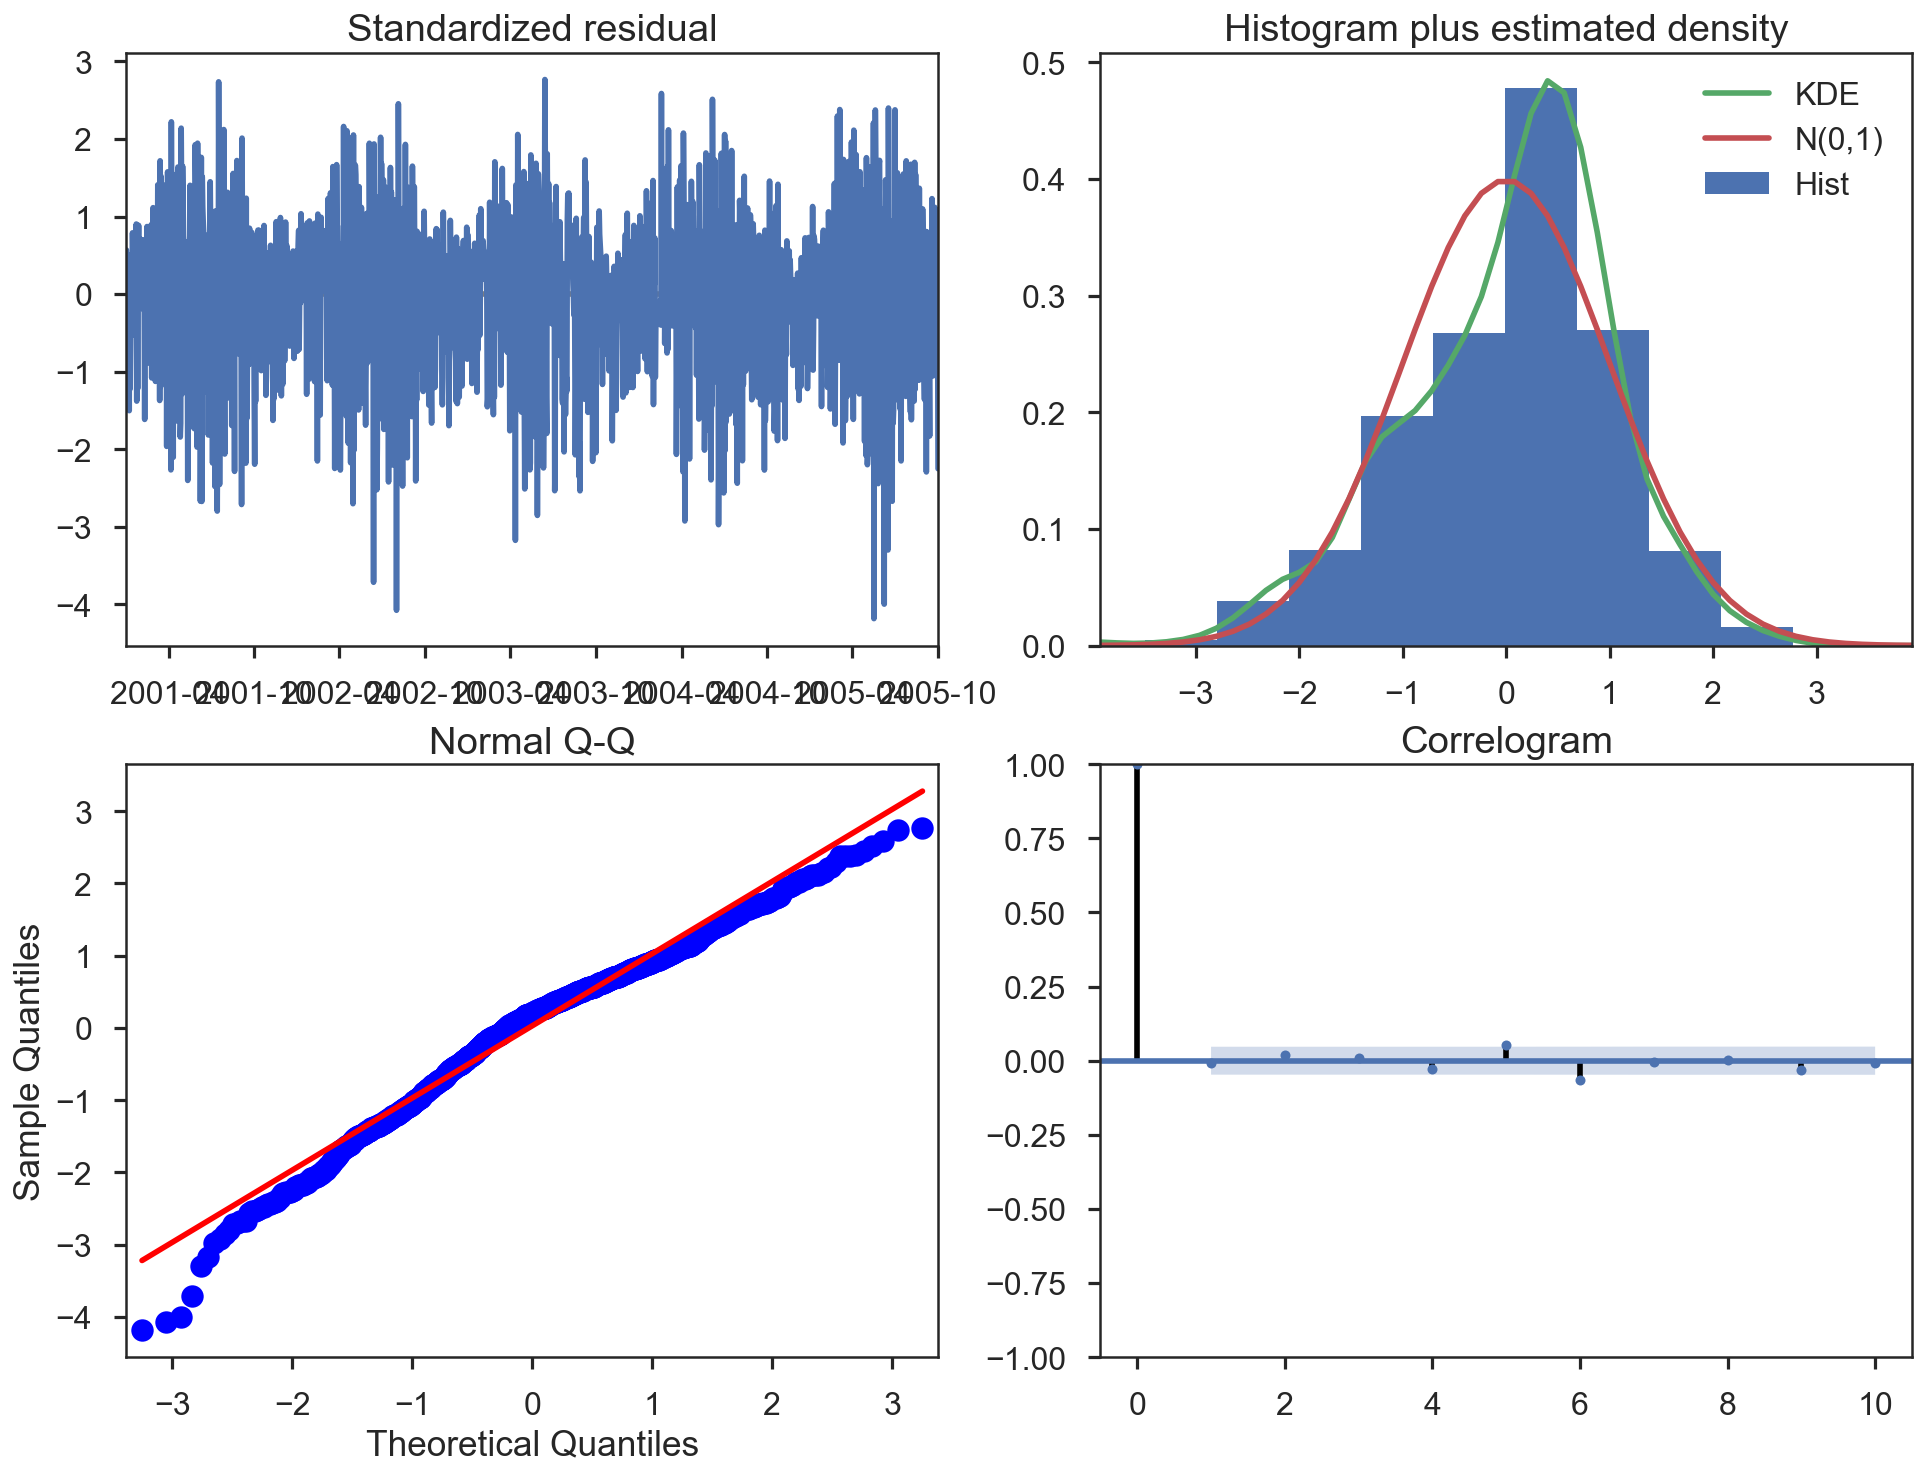

In [32]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals
model_results.plot_diagnostics(figsize=(16, 12));

### Test stationary (Dick-Fuller)

In [33]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

In [34]:
test_stationarity(daily_ts_short['GHI'])

Test Statistic                  -2.33294
p-value                          0.16156
#Lags Used                      25.00000
Number of Observations Used   1799.00000
Critical Value (5%)             -2.86315
Critical Value (1%)             -3.43399
Critical Value (10%)            -2.56763
dtype: float64

In [35]:
test_stationarity(diff_daily_ts_short)

Test Statistic                  -8.63642
p-value                          0.00000
#Lags Used                      24.00000
Number of Observations Used   1435.00000
Critical Value (5%)             -2.86356
Critical Value (1%)             -3.43492
Critical Value (10%)            -2.56784
dtype: float64

## We can observe after remove the seasonality, the series is stationary based on the Dick-Fuller test

In [38]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [39]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)


        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

### Run model grid search

In [ ]:
# run model grid search

p_min = 0
d_min = 0
q_min = 0
p_max = 3
d_max = 1
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=365

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(daily_ts_short['GHI'],
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

In [1]:
# choose a model

df_results.sort_values(by='bic').head(10)

NameError: name 'df_results' is not defined

## Best Model

**SARIMA (1 0 0) (0 1 1 12)**

In [4]:
mod = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,0), seasonal_order=(0,1,1,365), simple_differencing=False)
sarima_best = mod.fit()
print(sarima_best.summary())

NameError: name 'ts_train' is not defined

### Test Statistic of the model residuals 

We want to make sure after removing the trend, autocorrlation, and seasonality, the series (residual) is white noise

* Test of heteroskedasticity (Null is no heteroskedasticity)
* Test of normality (Jarque-Bera) (Null is normally distributed)
* Test of serial correlation (Ljung-Box) (Nuall is independent)
* Test residual is stationary and invertible

In [47]:
# Define testing Methods
het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

# Run test
het_stat, het_p = sarima_best.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = sarima_best.test_normality(norm_method)[0]
sercor_stat, sercor_p = sarima_best.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(sarima_best.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(sarima_best.maroots) > 1)

# display results
print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

Test heteroskedasticity of residuals (breakvar): stat=0.665, p=0.214

Test normality of residuals (jarquebera): stat=2.112, p=0.348

Test serial correlation of residuals (ljungbox): stat=47.053, p=0.206

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


## Model performance evaluation (in-sample fit)

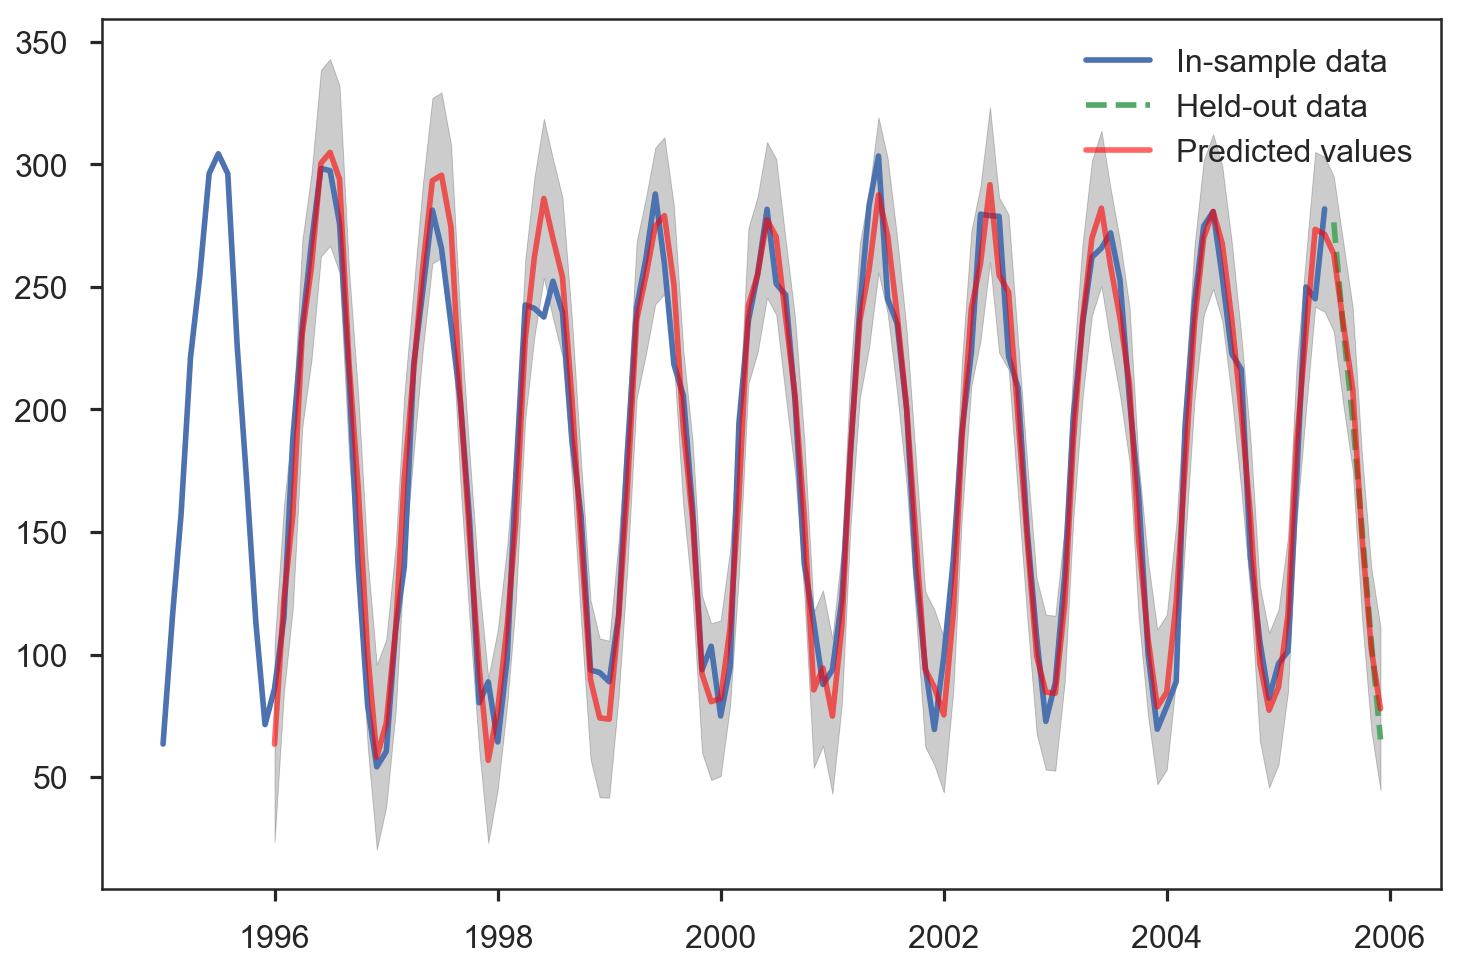

In [38]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_best.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_best.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                  end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

### Define some metrics

In [39]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

### Forecasting and forecast evaluation

In [55]:
rmse = get_rmse(ts_test, pred_mean.loc[ts_test.index])
print("Root Mean Square Error: {:.3f}".format(rmse))

mape = get_mape(ts_test, pred_mean.loc[ts_test.index])
print("Mean Absolute Percentage Error: {:.3f}%".format(mape))

mase = get_mase(ts_test, pred_mean.loc[ts_test.index])
print("Mean Absolute Scale Error: {:.3f}".format(mase))

Root Mean Square Error: 9.194
Mean Absolute Percentage Error: 6.049%
Mean Absolute Scale Error: 1.152
